In [1]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
!export OMP_NUM_THREADS=1
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

!export TF_ENABLE_ONEDNN_OPTS=0
!export XLA_FLAGS="--xla_gpu_cuda_data_dir=$CONDA_PREFIX/lib"
!echo $CONDA_PREFIX
!echo $LD_LIBRARY_PATH


2024-06-19 14:42:21.851318: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-19 14:42:21.877456: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 14:42:22.231806: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[]


2024-06-19 14:42:22.790942: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


/home/radiology/miniconda3/envs/torch-env



In [2]:
import pandas as pd

images = pd.read_csv('../datasets/images_dataset_clean4.csv')
reports = pd.read_csv('../datasets/report_dataset_clean4.csv')
# print(reports['body_part'])
data = reports[['id', 'body_part']]
# data.info()

df = pd.merge(images[['id','image_path']], data, on='id')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3012 entries, 0 to 3011
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          3012 non-null   int64 
 1   image_path  3012 non-null   object
 2   body_part   3012 non-null   object
dtypes: int64(1), object(2)
memory usage: 70.7+ KB


In [3]:
df = df.drop(columns=['id'])
df.head(5)

,image_path,body_part
0,../datasets/radiology_clean/abodemen_3_posisi/...,abdomen
1,../datasets/radiology_clean/abodemen_3_posisi/...,abdomen
2,../datasets/radiology_clean/abodemen_3_posisi/...,abdomen
3,../datasets/radiology_clean/abodemen_3_posisi/...,abdomen
4,../datasets/radiology_clean/abodemen_3_posisi/...,abdomen


In [4]:
import torch
import torch.nn as nn
# from torchinfo import summary

class InvertedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expansion, stride):
        super(InvertedResidualBlock, self).__init__()

        self.stride = stride
        self.expansion_layer = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * expansion, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_channels * expansion),
            nn.ReLU6(inplace=True)
        )

        self.depthwise_layer = nn.Sequential(
            nn.Conv2d(in_channels * expansion, in_channels * expansion, kernel_size=3, stride=stride, padding=1, groups=in_channels * expansion, bias=False),
            nn.BatchNorm2d(in_channels * expansion),
            nn.ReLU6(inplace=True)
        )

        self.pointwise_layer = nn.Sequential(
            nn.Conv2d(in_channels * expansion, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        out = self.expansion_layer(x)
        out = self.depthwise_layer(out)
        out = self.pointwise_layer(out)

        # if self.stride == 1:
        #     out = out + x

        return out

class InvertedResidualBlockTranspose(nn.Module):
    def __init__(self, in_channels, out_channels, t=6, stride=1):
        super(InvertedResidualBlockTranspose, self).__init__()

        self.stride = stride

        self.expansion_layer = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * t, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_channels * t),
            nn.ReLU6(inplace=True)
        )

        self.depthwise_layer_transpose = nn.Sequential(
            nn.ConvTranspose2d(in_channels * t, in_channels * t, kernel_size=3, stride=stride, padding=1,
                               output_padding=(0 if stride == 1 else 1), groups=in_channels * t, bias=False),
            nn.BatchNorm2d(in_channels * t),
            nn.ReLU6(inplace=True)
        )

        self.pointwise_layer_transpose = nn.Sequential(
            nn.ConvTranspose2d(in_channels * t, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        out = self.expansion_layer(x)
        out = self.depthwise_layer_transpose(out)
        out = self.pointwise_layer_transpose(out)

        return out


class MobileNetV2CAE(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(MobileNetV2CAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 224, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(224),
            nn.ReLU6(inplace=True),
            InvertedResidualBlock(224, 16, 1, 1),
            InvertedResidualBlock(16, 24, 6, 2),
            InvertedResidualBlock(24, 24, 6, 1),
            InvertedResidualBlock(24, 32, 6, 2),
            InvertedResidualBlock(32, 32, 6, 1),
            InvertedResidualBlock(32, 32, 6, 1),
            InvertedResidualBlock(32, 64, 6, 2),
            InvertedResidualBlock(64, 64, 6, 1),
            InvertedResidualBlock(64, 64, 6, 1),
            InvertedResidualBlock(64, 64, 6, 1),
            InvertedResidualBlock(64, 96, 6, 1),
            InvertedResidualBlock(96, 96, 6, 1),
            InvertedResidualBlock(96, 96, 6, 1),
            InvertedResidualBlock(96, 160, 6, 2),
            InvertedResidualBlock(160, 160, 6, 1),
            InvertedResidualBlock(160, 160, 6, 1),
            InvertedResidualBlock(160, 320, 6, 1)
        )

        self.decoder = nn.Sequential(
            InvertedResidualBlockTranspose(320, 160, 6, 1),
            InvertedResidualBlockTranspose(160, 160, 6, 1),
            InvertedResidualBlockTranspose(160, 160, 6, 2),
            InvertedResidualBlockTranspose(160, 96, 6, 1),
            InvertedResidualBlockTranspose(96, 96, 6, 1),
            InvertedResidualBlockTranspose(96, 96, 6, 1),
            InvertedResidualBlockTranspose(96, 64, 6, 1),
            InvertedResidualBlockTranspose(64, 64, 6, 1),
            InvertedResidualBlockTranspose(64, 64, 6, 1),
            InvertedResidualBlockTranspose(64, 64, 6, 1),
            InvertedResidualBlockTranspose(64, 32, 6, 2),
            InvertedResidualBlockTranspose(32, 32, 6, 1),
            InvertedResidualBlockTranspose(32, 32, 6, 1),
            InvertedResidualBlockTranspose(32, 24, 6, 2),
            InvertedResidualBlockTranspose(24, 24, 6, 1),
            InvertedResidualBlockTranspose(24, 16, 6, 2), # Change stride from 1 to 2
            nn.ConvTranspose2d(16, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = MobileNetV2CAE(in_channels=3)

# Instantiate the model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = "cpu"
#model = model.to(device)


# print(summary(model, input_size=(3, 224, 224), device=device.type))

In [5]:
# from sklearn.model_selection import train_test_split

# X = df['image_path']
# y = df['body_part']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

In [6]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
        
transform = transforms.Compose([
    transforms.Resize((224, 224))
    # transforms.ToTensor(),
    # transforms.
    # transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

X = CustomImageDataset(df, "", transform = transform)

In [7]:
from torch.utils.data import random_split

train_size = int(0.8 * len(X))
test_size = len(X) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(X, [train_size, test_size])

In [8]:
print(len(train_dataset))
print(len(test_dataset))

2409
603


In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# from torchvision.datasets import CIFAR10
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt


# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# get dataset
# train_dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
# test_dataset = CIFAR10(root='./data', train=False, transform=transform, download=True)

# train_dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
# test_dataset = CIFAR10(root='./data', train=False, transform=transform, download=True)

### ZY: reduced batch_size from 100 to 32 #############################
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
#######################################################################

In [10]:
# print(train_loader)

In [11]:
# Hyperparameters
num_epochs = 5
learning_rate = 0.001

# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MobileNetV2CAE(in_channels=3).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
# Training the model
model.train()
model.to(device)
# print(model.weights.dtype)
for epoch in range(num_epochs):
    print("===> Epoch: ", epoch)
    for i, (images, _) in enumerate(train_loader):
        
        ### ZY: convert images from uint8 to float ###
        images = images.float()
        ##############################################
        
        images = images.to(device)
        outputs = model(images)
        # print(outputs.dtype)
        # print(images.dtype)
        loss = criterion(outputs, images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

===> Epoch:  0
===> Epoch:  1
===> Epoch:  2
===> Epoch:  3
===> Epoch:  4


/tmp/ipykernel_3755704/2174336921.py:27: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  indices = labels == i


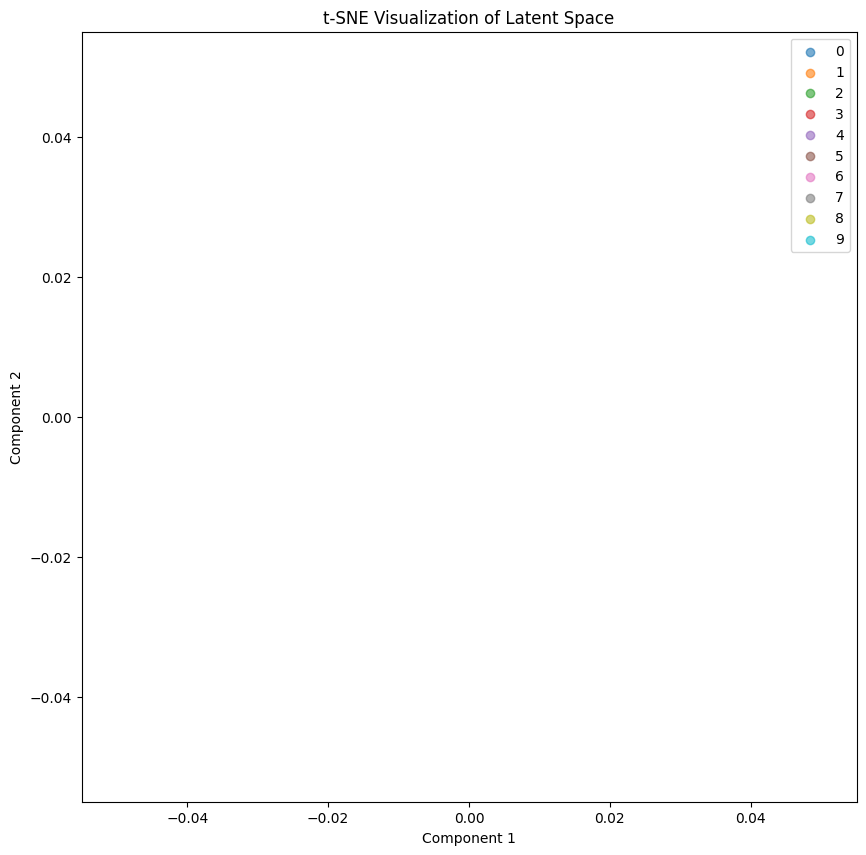

In [13]:
model.eval()

latent_space = []
labels = []

with torch.no_grad():
    for i, (images, lbls) in enumerate(test_loader):
        
        ### ZY: convert images from uint8 to float ###
        images = images.float()
        ##############################################
        
        images = images.to(device)
        encoded = model.encoder(images).view(images.size(0), -1).cpu().numpy()
        latent_space.append(encoded)
        labels.extend(lbls)

latent_space = np.vstack(latent_space)
labels = np.array(labels)

tsne = TSNE(n_components=2, random_state=42)
latent_2D = tsne.fit_transform(latent_space)

# Visualize the latent space using t-SNE
plt.figure(figsize=(10, 10))
for i in range(10):
    indices = labels == i
    plt.scatter(latent_2D[indices, 0], latent_2D[indices, 1], label=f'{i}', alpha=0.6)

plt.legend()
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE Visualization of Latent Space')
plt.show()
